In [1]:
# #!/usr/bin/env python

# """Notebook for rapid prompt-based annotation. Box to mask using Segment Anything Model"""

# __author__      = "Sahib Julka <sahib.julka@uni-passau.de>"
# __copyright__   = "GPL"


In [2]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
sys.path.append('../src')
from utils import encode_image
import pandas as pd

import cv2
import numpy as np
import supervision as sv
from os.path import expanduser

In [3]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
trained_models = main_path + "scripts/notebooks/trained_models/"
notebooks_path = main_path + "scripts/notebooks/"

In [4]:
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = main_path+"/sam/sam_vit_h_4b8939.pth"

In [5]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [6]:
# df = pd.read_csv("/root/Master_Thesis/data/dataframes/brain_df_train.csv")
# df = pd.read_csv("/root/Master_Thesis/data/dataframes/aerial_df.csv")
df = pd.read_csv(dataframes_path+"lunar_df_test.csv")

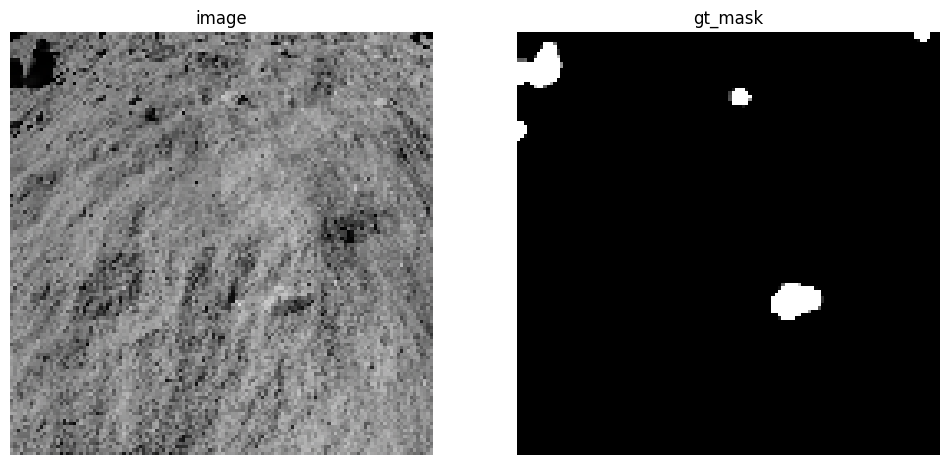

In [78]:
# i = np.random.randint(1, len(df))
i=1
import supervision as sv

image = np.load(df["images"][i], allow_pickle=True)
gt_mask = np.load(df["masks"][i], allow_pickle=True)
# gt_mask = np.sum(gt_mask, axis=2)
sv.plot_images_grid(
    images=[image, gt_mask],
    grid_size=(1, 2),
    titles=['image', 'gt_mask']
)

In [79]:
# print(resized_image.shape)

In [83]:
type(gt_mask[0][0])

numpy.uint8

In [68]:
def getBoxes(image, gt_mask):
    contours, _ = cv2.findContours(gt_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        cnts.append(box)
    boxes = torch.Tensor(np.array(cnts)).to(DEVICE)
    transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image.shape[:2])
    return transformed_boxes                                                                                                                           
    

In [69]:
boxes = getBoxes(image, gt_mask)

In [70]:
len(boxes)

5

In [96]:
contours, _ = cv2.findContours(gt_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    box = np.array([x, y, x+w, y+h])
    cnts.append(box)
boxes = torch.Tensor(np.array(cnts)).to(DEVICE)

mask_predictor.set_image(image)

transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image.shape[:2])

masks, box_scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes=transformed_boxes,
    multimask_output=False
)
# mask = masks.sum(axis=0).cpu().numpy()[0]

In [97]:
masks = masks.cpu().numpy()
box_scores = box_scores.cpu().numpy()
best_matches = []
for i in range(len(box_scores)):
    best_matches .append(masks[i][np.argmax(box_scores[i])])
    
mask = sum(best_matches)
mask = np.array(mask>0, dtype=np.uint8)



In [98]:
mask.shape

(128, 128)

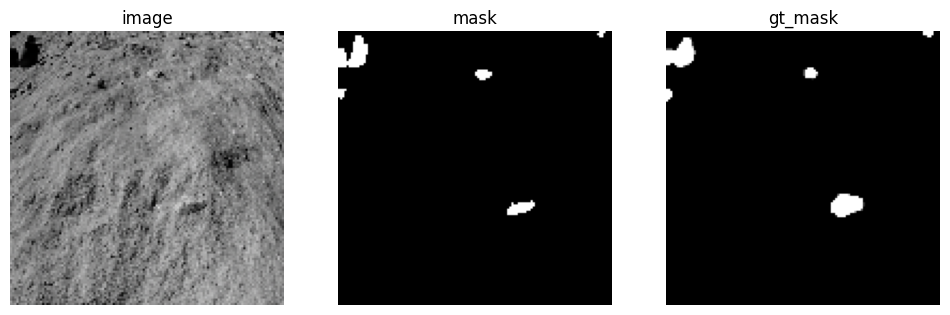

In [99]:
sv.plot_images_grid(
    #images=[image_rgb, mask[0], resized_mask],
    images=[image_rgb, mask, gt_mask],
    grid_size=(1, 3),
    titles=['image', 'mask', 'gt_mask']
)

In [77]:
masks, scores, logits = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
# masks = masks.sum(axis = 0).cpu().numpy()

NameError: name 'input_point' is not defined

In [34]:
masks.shape

(3, 256, 256)

In [73]:
box_scores = box_scores.cpu().numpy()

In [74]:
scores

array([0.71701795, 0.7383852 , 0.8307098 ], dtype=float32)

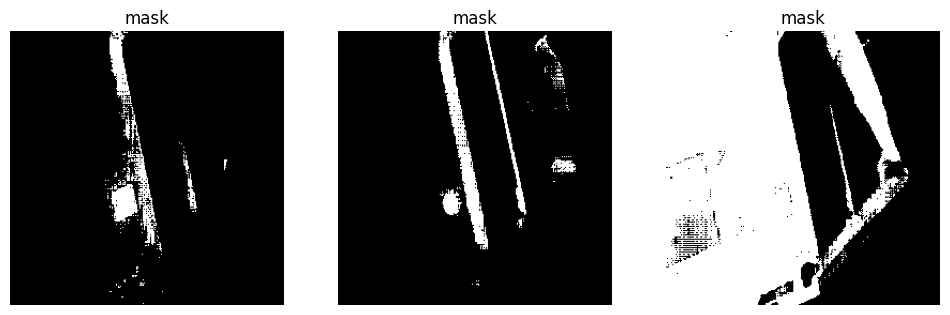

In [75]:
sv.plot_images_grid(
    #images=[image_rgb, mask[0], resized_mask],
    images=masks,
    grid_size=(1, 3),
    titles=['mask', 'mask', 'mask']
)

In [76]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [77]:
box_mask.shape

(1, 256, 256)

In [78]:
new_masks = np.concatenate((masks, box_mask), axis=0)
new_scores = np.concatenate((scores, box_scores[0]))

In [79]:
avg_mask = sum(new_masks)/len(new_masks)
avg_mask = np.expand_dims(avg_mask, axis=0)
avg_mask = np.array(avg_mask>0.9, dtype=np.float64)
avg_mask.shape

(1, 256, 256)

In [80]:
all_masks = np.concatenate((new_masks, avg_mask), axis=0)
all_masks.shape

(5, 256, 256)

In [81]:
all_scores = np.concatenate((new_scores, np.array([1.])))

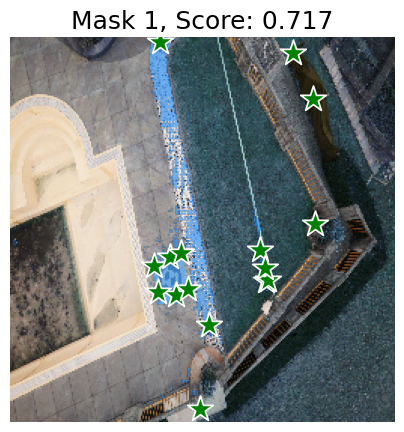

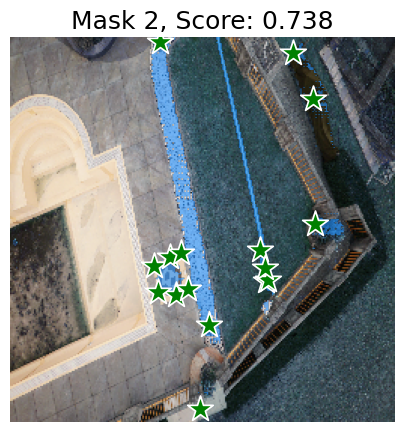

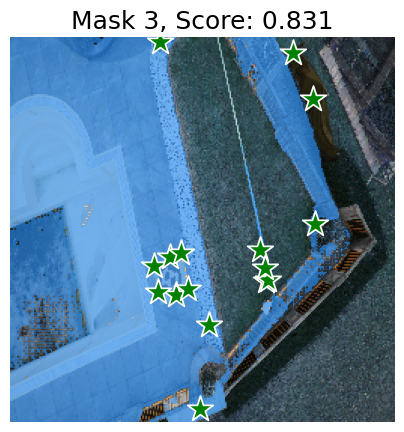

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


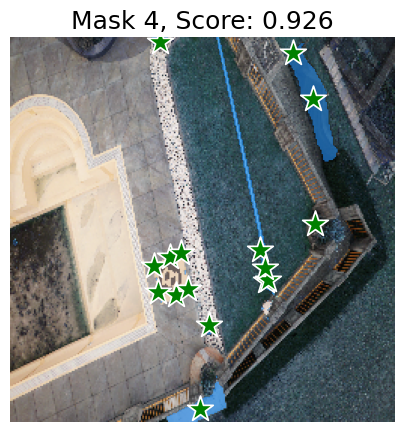

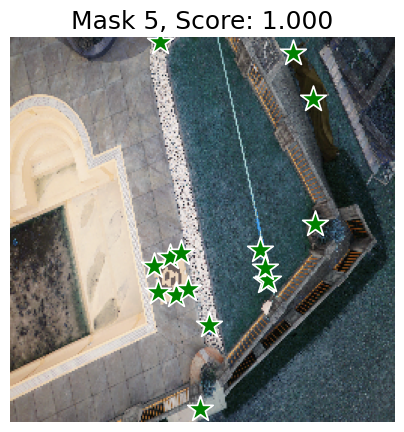

In [82]:
for i, (mask, score) in enumerate(zip(all_masks, all_scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [263]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
# mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
# mask_annotator = sv.MaskAnnotator(color=sv.Color(r=255, g=0, b=0))
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup="INDEX")

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=box_mask),
    mask=box_mask
)
detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=resized_image.copy(), detections=detections, skip_label=True)
# segmented_image = mask_annotator.annotate(scene=resized_image.copy(), detections=detections)

source_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)


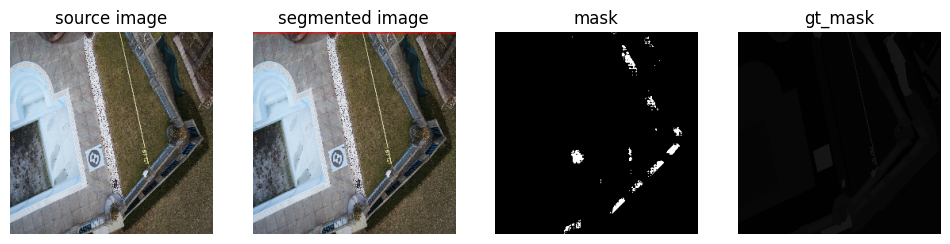

In [264]:
sv.plot_images_grid(
    # images=[source_image, segmented_image, mask[0], resized_mask],
    images=[image, segmented_image, mask, gt_mask],
    grid_size=(1, 4),
    titles=['source image', 'segmented image', 'mask', 'gt_mask']
)

In [10]:
images = []
masks=[]
i = 0
num =0

while i < len(df) and num <5:
    mask = cv2.imread(df["masks"][i])
    if mask.sum() != 0:
        masks.append(mask)
        images.append(cv2.imread(df["images"][i]))        
        num+=1
    i+=1

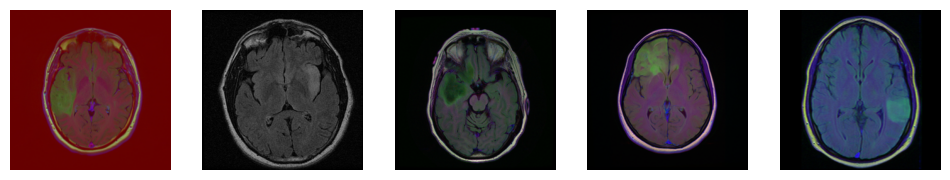

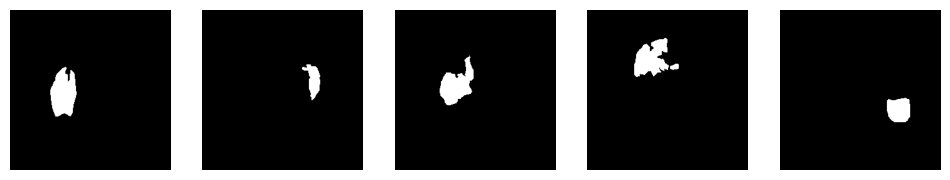

In [11]:
sv.plot_images_grid(
    images=images,
    grid_size=(1, len(images)),
)

sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
)

In [12]:
masks[0].shape

(256, 256, 3)

In [13]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device) 
    return image.permute(2, 0, 1).contiguous()

In [14]:
# batched_input = [
#      {
#          'image': prepare_image(images[0], resize_transform, DEVICE),
#          'boxes': getBoxes(images[0], masks[0]),
#          'original_size': images[0].shape[:2]
#      },
#      {
#          'image': prepare_image(images[1], resize_transform, DEVICE),
#          'boxes': getBoxes(images[1], masks[1]),
#          'original_size': images[1].shape[:2]
#      }
# ]

In [15]:
def getBatch(images, masks):
    return [{"image": prepare_image(image, resize_transform, DEVICE),
             "boxes": getBoxes(image, mask),
             "original_size": image.shape[:2]} for image, mask in zip(images, masks)]

In [18]:
batch = getBatch(images, masks)

In [19]:
len(batch)

5

In [20]:
# batched_output = sam(batched_input, multimask_output=False)
batched_output = sam(batch, multimask_output=False)


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.00 GiB (GPU 0; 11.17 GiB total capacity; 8.47 GiB already allocated; 2.04 GiB free; 8.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [51]:
batched_output[0].keys()
output_masks=[]
for i in range(len(batched_output)):
    for mask in batched_output[i]["masks"]:
        mask = mask.sum(axis = 0).cpu().numpy()
        output_masks.append(mask)

In [52]:
output_masks[0].shape

(256, 256)

In [53]:
import torch.nn.functional as F
out = torch.rand((256, 1, 256, 256))
prob = F.sigmoid(out)

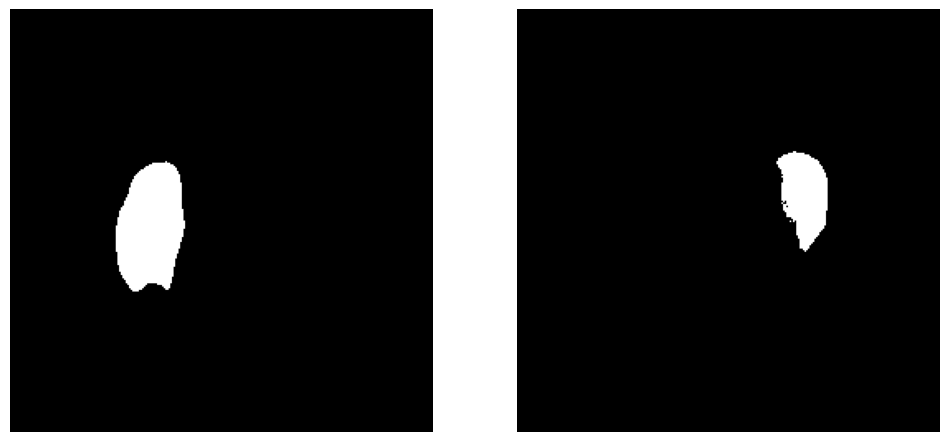

In [54]:
sv.plot_images_grid(
    images=output_masks,
    grid_size=(1, 2),
)

In [ ]:
# box_annotator = sv.BoxAnnotator(color=sv.Color.red())
# # mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
# # mask_annotator = sv.MaskAnnotator(color=sv.Color(r=255, g=0, b=0))
# mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup="INDEX")

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=mask),
#     mask=mask
# )
# detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
# segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# sv.plot_images_grid(
#     images=[source_image, segmented_image],
#     grid_size=(1, 2),
#     titles=['source image', 'segmented image']
# )

In [69]:
# import supervision as v

# sv.plot_images_grid(
#     images=mask,
#     grid_size=(1, 2),
#     size=(16, 4)
# )

In [366]:
# os.makedirs("../data/processed/masks+/", exist_ok = True)
# np.save('../data/processed/masks+/{}.npy'.format(filenames[i].split('.png')[0]), mask)

In [ ]:
class SAMOracle():
    
    def __init__(self,
                 device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 model_type = "vit_h",
                 checkpoint_path = os.path.join("../sam","sam_vit_h_4b8939.pth"),
                 model = None,
                 default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
                ):
        
        self.device = device
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self.model = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
        self.mask_predictor = SamPredictor(self.model)
        self.default_box = default_box        
        
        
    
    def get_mask(self, img_path = None, img_rgb=None, boxes=None):
        
        if img_rgb is None:
            image_bgr = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            
        self.mask_predictor.set_image(img_rgb)
        
        if boxes is None:
            widget = BBoxWidget()
            widget.image = encode_image(img_path)
            boxes = []
            for box in widget.bboxes:
                box = np.array([
                    box['x'], 
                    box['y'], 
                    box['x'] + box['width'], 
                    box['y'] + box['height']
                ])
                boxes.append(box)
            boxes.append(np.array([
                        self.default_box['x'],
                        self.default_box['y'],
                        self.default_box['x'] + self.default_box['width'],
                        self.default_box['y'] + self.default_box['height']]))
            boxes = torch.Tensor(boxes).to(self.device)
        transformed_boxes = self.mask_predictor.transform.apply_boxes_torch(boxes, img_rgb.shape[:2])


        masks, scores, logits = self.mask_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes=transformed_boxes,
            multimask_output=False
        )
        mask = masks.sum(axis = 0).cpu().numpy()
        return mask
    
    def annotate_mask(self, img_path:str):
        widget = BBoxWidget()
        widget.image = encode_image(img_path)
        boxes = []
        for box in widget.bboxes:
            box = np.array([
                box['x'], 
                box['y'], 
                box['x'] + box['width'], 
                box['y'] + box['height']
            ])
            boxes.append(box)
        boxes.append(np.array([
                    self.default_box['x'],
                    self.default_box['y'],
                    self.default_box['x'] + self.default_box['width'],
                    self.default_box['y'] + self.default_box['height']]))
        boxes = torch.Tensor(boxes).to(self.device)

        image_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
        mask = self.get_mask(img_rgb=img_rgb, boxes=boxes)
        detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=mask),
                                   mask=mask)
        
        detections = detections[detections.area == np.max(detections.area)]

        segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
        return segmented_image